In [3]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from numpy.random import RandomState
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from plot_fun import *

In [4]:
# Some hyper parameters
train_data_frac = 0.9
batch_size = 5000
learning_rate = 0.00005
number_of_epochs = 10
num_of_input = 3

#####This neural net was used in our bachelor thisis

In [11]:

path_to_save_model_to = r'saved_models/final_model_azm_no_feature3.pth'
path_to_load_from = r'saved_models/final_model_azm_no_feature3.pth'
path_to_data = r'data/params_inc_azi.csv'
train_path = Path(r'data/train_data.csv')
val_path = Path(r'data/val_data.csv')


In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Running on the GPU')
else:
    device = torch.device("cpu")
    print('Running on the CPU')


Running on the GPU


In [12]:
df = pd.read_csv(path_to_data, names=['SWH', 'mean', 'var', 'azm', 'flag'])
# Removes null values
df.drop(df[df['SWH'].isnull()].index, inplace=True)
rng = RandomState(4)

df['mean'] = (df['mean'] - df['mean'].mean()) / (df['mean'].std())
df['var'] = (df['var'] - df['var'].mean()) / (df['var'].std())
df['azm'] = (df['azm'] - df['azm'].mean()) / (df['azm'].std())
df = df[['mean', 'var', 'azm', 'SWH']]

train = df.sample(frac=train_data_frac, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

train_path.parent.mkdir(parents=True, exist_ok=True)
val_path.parent.mkdir(parents=True, exist_ok=True)
train.to_csv(train_path, index=False)
test.to_csv(val_path, index=False)

In [13]:

class CustomCsvDataset:
    def __init__(self, dataset):
        self.dataset = dataset.to(device)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_data = self.dataset[idx, 0:(self.dataset.size(1) - 1)]
        label = self.dataset[idx, self.dataset.size(1) - 1]
        return input_data, label


In [14]:


# the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hid1 = torch.nn.Linear(num_of_input, 30)
        self.hid2 = torch.nn.Linear(30, 30)
        self.hid3 = torch.nn.Linear(30, 30)
        self.hid4 = torch.nn.Linear(30, 30)
        self.hid5 = torch.nn.Linear(30, 30)
        self.hid6 = torch.nn.Linear(30, 30)
        self.hid7 = torch.nn.Linear(30, 30)
        self.hid8 = torch.nn.Linear(30, 30)
        self.output = torch.nn.Linear(30, 1)

    def forward(self, x):
        z = torch.relu(self.hid1(x))
        z = torch.relu(self.hid2(z))
        z = torch.relu(self.hid3(z))
        z = torch.relu(self.hid4(z))
        z = torch.relu(self.hid5(z))
        z = torch.relu(self.hid6(z))
        z = torch.relu(self.hid7(z))
        z = torch.relu(self.hid8(z))
        z = self.output(z)
        return z

In [15]:
# to get results that can be repeated
torch.manual_seed(4)
np.random.seed(4)

training_data = np.loadtxt(train_path, dtype=np.float32, delimiter=",", skiprows=1)
training_data = torch.from_numpy(training_data)
train_data = CustomCsvDataset(training_data)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

validation_data = np.loadtxt(val_path, dtype=np.float32, delimiter=",", skiprows=1)
validation_data = torch.from_numpy(validation_data)
val_data = CustomCsvDataset(validation_data)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

net = Net().to(device)
# loads the old model
if load_model:
    net.load_state_dict(torch.load(path_to_load_from, map_location=device))

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
net.train()

Net(
  (hid1): Linear(in_features=3, out_features=30, bias=True)
  (hid2): Linear(in_features=30, out_features=30, bias=True)
  (hid3): Linear(in_features=30, out_features=30, bias=True)
  (hid4): Linear(in_features=30, out_features=30, bias=True)
  (hid5): Linear(in_features=30, out_features=30, bias=True)
  (hid6): Linear(in_features=30, out_features=30, bias=True)
  (hid7): Linear(in_features=30, out_features=30, bias=True)
  (hid8): Linear(in_features=30, out_features=30, bias=True)
  (output): Linear(in_features=30, out_features=1, bias=True)
)

In [16]:
start_time = time.time()
for epoch in range(number_of_epochs):
    torch.manual_seed(1+epoch)  # recovery reproducibility
    epoch_loss_train = 0.0
    epoch_loss_val = 0.0

    net.train()
    for (idx, X) in enumerate(train_dataloader):
        (input_data, label) = X
        optimizer.zero_grad()
        output = net(input_data)
        output = torch.squeeze(output)
        train_loss = loss_func(output, label)
        epoch_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

    net.eval()
    for (idx, X) in enumerate(val_dataloader):
        with torch.no_grad():
            (input_data, label) = X
            output = net(input_data)
            output = torch.squeeze(output)
            val_loss = loss_func(output, label)
            epoch_loss_val += val_loss.item()

    if epoch % 1 == 0 or epoch == number_of_epochs-1:
        print(f'epoch {epoch} train loss = {epoch_loss_train}')
        print(f'epoch {epoch}   val loss = {epoch_loss_train}')

end_time = time.time()
print(f'time for the training: {end_time - start_time}')

epoch 0 train loss = 2.8680912852287292
epoch 0   val loss = 2.8680912852287292
epoch 1 train loss = 2.8561234027147293
epoch 1   val loss = 2.8561234027147293
epoch 2 train loss = 2.8542263731360435
epoch 2   val loss = 2.8542263731360435
epoch 3 train loss = 2.8528334870934486
epoch 3   val loss = 2.8528334870934486
epoch 4 train loss = 2.857624761760235
epoch 4   val loss = 2.857624761760235
epoch 5 train loss = 2.8572837188839912
epoch 5   val loss = 2.8572837188839912
epoch 6 train loss = 2.8594340085983276
epoch 6   val loss = 2.8594340085983276
epoch 7 train loss = 2.8646703585982323
epoch 7   val loss = 2.8646703585982323
epoch 8 train loss = 2.8598906248807907
epoch 8   val loss = 2.8598906248807907
epoch 9 train loss = 2.858303003013134
epoch 9   val loss = 2.858303003013134
time for the training: 16.97296118736267


In [17]:
def accuracy(model, ds, ok_error):
        correct = 0
        total = 0
        for val_data, label in ds:
            with torch.no_grad():
                output = model(val_data)
            abs_delta = np.abs(output.item()-label.item())
            if abs_delta < ok_error:
                correct += 1
            total += 1
        acc = correct/total
        return acc

In [18]:
net.eval()
ok_error = 0.2
train_acc = accuracy(net, train_data, ok_error)
print(f'train accuracy: {train_acc}')
val_acc = accuracy(net, val_data, ok_error)
print(f'validation ({ok_error}m) accuracy: {val_acc}')

train accuracy: 0.48926505172984236
validation (0.2m) accuracy: 0.48519233864477707


In [19]:
torch.save(net.state_dict(), path_to_save_model_to)

In [20]:
def get_model_guess_vs_target_arr(model, ds):
        model_guess_arr = np.empty(len(ds))
        target_arr = np.empty(len(ds))
        for i, data in enumerate(ds):
            val_data, label = data
            with torch.no_grad():
                output = model(val_data)
            target_arr[i] = label
            model_guess_arr[i] = output

        return target_arr, model_guess_arr

In [21]:
target_arr, model_guess_arr = get_model_guess_vs_target_arr(net, val_data)
# Calculates RMSE, R-value and MAE
mse = mean_squared_error(target_arr, model_guess_arr)
rmse = np.sqrt(mse)
print(f"RMSE for full validation set: {rmse:.3f}")

res = r2_score(target_arr, model_guess_arr)
res = np.sqrt(res)
print(f"R-value for full validation set: {res:.3f}")

mean_absolute_error = np.mean(np.abs(target_arr - model_guess_arr))
print(f"Mean absolute error: {mean_absolute_error:.3f}")

bias_error = np.mean(target_arr - model_guess_arr)
print(f"bias error: {bias_error:.3f}")

RMSE for full validation set: 0.357
R-value for full validation set: 0.866
Mean absolute error: 0.270
bias error: -0.006


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


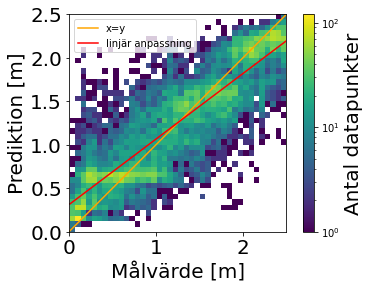

In [22]:
plot_hist2d(target_arr, model_guess_arr)
